## Targeted Classifier Experiment


In [1]:
%load_ext autoreload
%autoreload 2

import sklearn
import json


with open("../../data/dataset.json") as f:
    data = json.load(f)


## Exploratorio

In [2]:
import pandas as pd

label2id = {
    "NEG": 0,
    "NEU": 1,
    "POS": 2
}

id2label = {v:k for k, v in label2id.items()}

df = pd.DataFrame([{
    "id": x["id"],
    "sentence": x["titulo"],
    "target": target,
    "label": label2id[label],
} for x in data for (target, label) in x["labels"].items()])

df

,id,sentence,target,label
0,23,Barrio Aeroclub: la Izquierda propone urbaniza...,la Izquierda,2
1,24,Elecciones municipales: el #FITUnidad busca fo...,la izquierda,2
2,31,[Videos] Mirá todos los spots del Frente de Iz...,Frente de Izquierda Unidad,1
3,39,Entre el milagro de Macri y la grieta del pero...,Macri,2
4,39,Entre el milagro de Macri y la grieta del pero...,peronismo,0
...,...,...,...,...
2369,22611,"Resultados elecciones 2019: Alberto Fernández,...",Alberto Fernández,2
2370,22612,Elecciones 2019. La llamada de Macri a Alberto...,Macri,2
2371,22616,Video: el particular gesto de Cristina Kirchne...,Cristina Kirchner,1
2372,22617,Mauricio Macri hizo una gran campaña y Alberto...,Mauricio Macri,2


In [3]:
df["label"].value_counts()

2    940
1    742
0    692
Name: label, dtype: int64

Bien, está dentro de todo equilibrado

## Train test split

Lo hago sobre el dataset. No sería mejor hacerlo por oraciones?

In [4]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(df, random_state=2021, stratify=df["label"])

train_data, dev_data = train_test_split(train_data, random_state=2021, stratify=train_data["label"])

len(train_data), len(dev_data), len(test_data)

(1335, 445, 594)

## Armar dataset

In [5]:
from datasets import Dataset, Value, ClassLabel, Features


features = Features({
    'sentence': Value('string'),
    'target': Value('string'),
    'label': ClassLabel(num_classes=3, names=["neg", "neu", "pos"])
})

columns = ["sentence", "target", "label"]

train_dataset = Dataset.from_pandas(train_data[columns], features=features)
dev_dataset = Dataset.from_pandas(dev_data[columns], features=features)
test_dataset = Dataset.from_pandas(test_data[columns], features=features)

In [6]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

model_name = 'dccuchile/bert-base-spanish-wwm-uncased'

model = AutoModelForSequenceClassification.from_pretrained(
    model_name, return_dict=True, num_labels=len(id2label)
)

model.config.id2label = id2label
model.config.label2id = label2id

tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenizer.model_max_length = 128


Some weights of the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuc

In [7]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

model = model.to(device)

In [8]:
def tokenize(batch):
    return tokenizer(batch['sentence'], batch['target'], padding='max_length', truncation=True)

batch_size = 16
eval_batch_size = 8

train_dataset = train_dataset.map(tokenize, batched=True, batch_size=batch_size)
dev_dataset = dev_dataset.map(tokenize, batched=True, batch_size=eval_batch_size)
test_dataset = test_dataset.map(tokenize, batched=True, batch_size=eval_batch_size)

(array([ 14., 142., 227., 381., 254., 191.,  86.,  26.,  11.,   3.]),
 array([10. , 13.6, 17.2, 20.8, 24.4, 28. , 31.6, 35.2, 38.8, 42.4, 46. ]),
 <BarContainer object of 10 artists>)

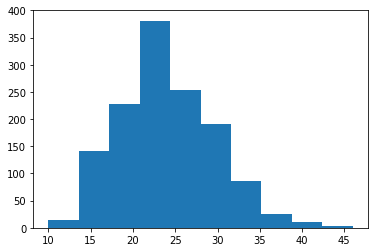

In [9]:
import matplotlib.pyplot as plt

lens = [sum(x["attention_mask"]) for x in train_dataset]


plt.hist(lens)

In [10]:
train_dataset[0].keys()

dict_keys(['attention_mask', 'input_ids', 'label', 'sentence', 'target', 'token_type_ids'])

In [11]:

def format_dataset(dataset):
    dataset = dataset.map(lambda x: {"labels": x["label"]})
    columns = ['input_ids', 'attention_mask', 'labels']
    if 'token_type_ids' in dataset.features:
        columns.append('token_type_ids')
    dataset.set_format(type='torch', columns=columns)
    return dataset

train_dataset = format_dataset(train_dataset)
dev_dataset = format_dataset(dev_dataset)
test_dataset = format_dataset(test_dataset)


In [12]:
from transformers import TrainingArguments, Trainer
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def compute_metrics(pred, id2label):
    """
    Compute metrics for Trainer
    """
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    ret = {}

    f1s = []
    precs = []
    recalls = []

    for i, cat in id2label.items():
        cat_labels, cat_preds = labels == i, preds == i
        precision, recall, f1, _ = precision_recall_fscore_support(
            cat_labels, cat_preds, average='binary', zero_division=0,
        )

        f1s.append(f1)
        precs.append(precision)
        recalls.append(recall)

        ret[cat.lower()+"_f1"] = f1
        ret[cat.lower()+"_precision"] = precision
        ret[cat.lower()+"_recall"] = recall

    _, _, micro_f1, _ = precision_recall_fscore_support(
        labels, preds, average="micro"
    )
    ret["micro_f1"] = micro_f1
    ret["macro_f1"] = torch.Tensor(f1s).mean()
    ret["macro_precision"] = torch.Tensor(precs).mean()
    ret["macro_recall"] = torch.Tensor(recalls).mean()

    ret["acc"] = accuracy_score(labels, preds)

    return ret

epochs = 5
warmup_proportion = 0.10
total_steps = (epochs * len(train_dataset)) // batch_size
warmup_steps = int(warmup_proportion * total_steps)

training_args = TrainingArguments(
    output_dir='./results/',
    num_train_epochs=epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=eval_batch_size,
    warmup_steps=warmup_steps,
    evaluation_strategy="epoch",
    do_eval=False,
    weight_decay=0.01,
    logging_dir='./logs',
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
)

trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=lambda x: compute_metrics(x, id2label=id2label),
    train_dataset=train_dataset,
    eval_dataset=dev_dataset,
)


In [13]:
trainer.train()

Epoch,Training Loss,Validation Loss,Neg F1,Neg Precision,Neg Recall,Neu F1,Neu Precision,Neu Recall,Pos F1,Pos Precision,Pos Recall,Micro F1,Macro F1,Macro Precision,Macro Recall,Acc,Runtime,Samples Per Second
1,No log,0.901950,0.652361,0.737864,0.584615,0.599455,0.482456,0.791367,0.565517,0.719298,0.465909,0.602247,0.605778,0.646540,0.613964,0.602247,2.240000,198.660000
2,No log,0.839599,0.698718,0.598901,0.838462,0.584071,0.758621,0.474820,0.744318,0.744318,0.744318,0.687640,0.675702,0.700613,0.685867,0.687640,2.233600,199.227000
3,No log,1.012727,0.716312,0.664474,0.776923,0.600000,0.712871,0.517986,0.744565,0.713542,0.778409,0.696629,0.686959,0.696962,0.691106,0.696629,2.250600,197.721000
4,No log,1.357641,0.684444,0.810526,0.592308,0.651341,0.696721,0.611511,0.727723,0.644737,0.835227,0.694382,0.687836,0.717328,0.679682,0.694382,2.123600,209.548000
5,No log,1.420027,0.723735,0.732283,0.715385,0.637681,0.642336,0.633094,0.739496,0.729282,0.750000,0.703371,0.700304,0.701300,0.699493,0.703371,2.262200,196.710000


TrainOutput(global_step=420, training_loss=0.4167713346935454, metrics={'train_runtime': 130.5036, 'train_samples_per_second': 3.218, 'total_flos': 563151377836800.0, 'epoch': 5.0, 'init_mem_cpu_alloc_delta': 54307, 'init_mem_gpu_alloc_delta': 0, 'init_mem_cpu_peaked_delta': 18258, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': 1136609, 'train_mem_gpu_alloc_delta': 1794117632, 'train_mem_cpu_peaked_delta': 95403625, 'train_mem_gpu_peaked_delta': 1338078720})

In [14]:
trainer.evaluate(test_dataset)

{'eval_loss': 1.3133471012115479,
 'eval_neg_f1': 0.7252747252747253,
 'eval_neg_precision': 0.6910994764397905,
 'eval_neg_recall': 0.7630057803468208,
 'eval_neu_f1': 0.6761363636363638,
 'eval_neu_precision': 0.7168674698795181,
 'eval_neu_recall': 0.6397849462365591,
 'eval_pos_f1': 0.7627118644067796,
 'eval_pos_precision': 0.759493670886076,
 'eval_pos_recall': 0.7659574468085106,
 'eval_micro_f1': 0.7255892255892256,
 'eval_macro_f1': 0.7213743329048157,
 'eval_macro_precision': 0.7224867939949036,
 'eval_macro_recall': 0.7229161262512207,
 'eval_acc': 0.7255892255892256,
 'eval_runtime': 2.8183,
 'eval_samples_per_second': 210.763,
 'epoch': 5.0,
 'eval_mem_cpu_alloc_delta': 65854,
 'eval_mem_gpu_alloc_delta': 0,
 'eval_mem_cpu_peaked_delta': 177186,
 'eval_mem_gpu_peaked_delta': 35173376}

In [15]:
model = trainer.model

In [16]:
from torch.nn import functional as F
def predict(sentence, target):
    """
    Return most likely class for the sentence
    """
    idx = torch.LongTensor(tokenizer.encode(sentence, target)).view(1, -1).to(device)
    print(tokenizer.decode(idx[0]))
    output = model(idx)
    probs = F.softmax(output.logits, dim=1).view(-1)
    probas = {id2label[i]:probs[i].item() for i in id2label}

    return probas



In [28]:
sentence = "Gran 2020 para Messi, pero bastante malo para Cristiano Ronaldo"

targets = ["Messi", "Cristiano Ronaldo"]

for target in targets:
    print(target)
    print(predict(sentence, target))

Messi
[CLS] gran 2020 para messi, pero bastante malo para cristiano ronaldo [SEP] messi [SEP]
{'NEG': 0.996861457824707, 'NEU': 0.0014492666814476252, 'POS': 0.0016892417334020138}
Cristiano Ronaldo
[CLS] gran 2020 para messi, pero bastante malo para cristiano ronaldo [SEP] cristiano ronaldo [SEP]
{'NEG': 0.9961989521980286, 'NEU': 0.0016664467984810472, 'POS': 0.0021345769055187702}


In [29]:
sentence = "Alberto Fernández: \"El gobierno de Macri fue un desastre\""

targets = ["Alberto Fernández", "Macri"]

for target in targets:
    print(target)
    print(predict(sentence, target))

Alberto Fernández
[CLS] alberto fernández : " el gobierno de macri fue un desastre " [SEP] alberto fernández [SEP]
{'NEG': 0.003726329654455185, 'NEU': 0.0006989876856096089, 'POS': 0.9955745935440063}
Macri
[CLS] alberto fernández : " el gobierno de macri fue un desastre " [SEP] macri [SEP]
{'NEG': 0.9968807697296143, 'NEU': 0.000385183171601966, 'POS': 0.0027340983506292105}


In [19]:
sentence = "Alberto Fernández: \"El gobierno de Xi Jin Ping fue un desastre\""

targets = ["Alberto Fernández", "Xi Jin Ping"]

for target in targets:
    print(target)
    print(predict(sentence, target))

Alberto Fernández
[CLS] alberto fernández : " el gobierno de xi jin ping fue un desastre " [SEP] alberto fernández [SEP]
{'NEG': 0.007715512532740831, 'NEU': 0.0009177132742479444, 'POS': 0.9913668036460876}
Xi Jin Ping
[CLS] alberto fernández : " el gobierno de xi jin ping fue un desastre " [SEP] xi jin ping [SEP]
{'NEG': 0.9885976314544678, 'NEU': 0.0005608819774352014, 'POS': 0.010841495357453823}


In [20]:
sentence = "Romina Del Plá denunció el ajuste de Alberto Fernández"

targets = ["Romina del Plá", "Alberto Fernández"]

for target in targets:
    print(target)
    print(predict(sentence, target))

Romina del Plá
[CLS] romina del plá denunció el ajuste de alberto fernández [SEP] romina del plá [SEP]
{'NEG': 0.002063739812001586, 'NEU': 0.0020946392323821783, 'POS': 0.9958416819572449}
Alberto Fernández
[CLS] romina del plá denunció el ajuste de alberto fernández [SEP] alberto fernández [SEP]
{'NEG': 0.07176734507083893, 'NEU': 0.018676303327083588, 'POS': 0.9095563292503357}


In [21]:
sentence = "El Gobierno confirmó el decreto para destrabar la compra de vacunas"

targets = ["Gobierno"]

for target in targets:
    print(target)
    print(predict(sentence, target))

Gobierno
[CLS] el gobierno confirmó el decreto para destrabar la compra de vacunas [SEP] gobierno [SEP]
{'NEG': 0.6214466094970703, 'NEU': 0.012440790422260761, 'POS': 0.3661125898361206}


In [22]:
sentence = "Cristina Kirchner acusa al Gobierno de corrupción en la compra de vacunas"

targets = ["Gobierno", "Cristina Kirchner"]

for target in targets:
    print(target)
    print(predict(sentence, target))

Gobierno
[CLS] cristina kirchner acusa al gobierno de corrupción en la compra de vacunas [SEP] gobierno [SEP]
{'NEG': 0.9695510268211365, 'NEU': 0.0012660573702305555, 'POS': 0.029182929545640945}
Cristina Kirchner
[CLS] cristina kirchner acusa al gobierno de corrupción en la compra de vacunas [SEP] cristina kirchner [SEP]
{'NEG': 0.02034047432243824, 'NEU': 0.0012733014300465584, 'POS': 0.9783862233161926}


In [23]:
sentence = "El duro comunicado de las empresas estadounidenses contra el Gobierno"

targets = ["Gobierno"]

for target in targets:
    print(target)
    print(predict(sentence, target))

Gobierno
[CLS] el duro comunicado de las empresas estadounidenses contra el gobierno [SEP] gobierno [SEP]
{'NEG': 0.9816378951072693, 'NEU': 0.0007543375249952078, 'POS': 0.017607828602194786}


In [24]:
sentence = "Ultiman negociaciones para cerrar acuerdo en la Ciudad entre Vidal y Bullrich"

targets = ["Vidal", "Bullrich"]

for target in targets:
    print(target)
    print(predict(sentence, target))

Vidal
[CLS] ultiman negociaciones para cerrar acuerdo en la ciudad entre vidal y bullrich [SEP] vidal [SEP]
{'NEG': 0.003342653624713421, 'NEU': 0.9826508164405823, 'POS': 0.014006558805704117}
Bullrich
[CLS] ultiman negociaciones para cerrar acuerdo en la ciudad entre vidal y bullrich [SEP] bullrich [SEP]
{'NEG': 0.07273595035076141, 'NEU': 0.9148545861244202, 'POS': 0.012409432791173458}


In [25]:
sentence = "\"Este Gobierno ha sido una lacra corrupta inmunda\" declaró Patricia Bullrich"

targets = ["Gobierno", "Bullrich"]

for target in targets:
    print(target)
    print(predict(sentence, target))

Gobierno
[CLS] " este gobierno ha sido una lacra corrupta inmunda " declaró patricia bullrich [SEP] gobierno [SEP]
{'NEG': 0.9476504921913147, 'NEU': 0.0005365539691410959, 'POS': 0.05181294307112694}
Bullrich
[CLS] " este gobierno ha sido una lacra corrupta inmunda " declaró patricia bullrich [SEP] bullrich [SEP]
{'NEG': 0.910385012626648, 'NEU': 0.0006816975655965507, 'POS': 0.0889333188533783}


Si lo ponemos adelante, sin embargo...

In [30]:
sentence = "Patricia Bullrich: \"Este Gobierno ha sido una lacra corrupta inmunda\""

targets = ["Gobierno", "Bullrich"]

for target in targets:
    print(target)
    print(predict(sentence, target))

Gobierno
[CLS] patricia bullrich : " este gobierno ha sido una lacra corrupta inmunda " [SEP] gobierno [SEP]
{'NEG': 0.1712493896484375, 'NEU': 0.0014692284166812897, 'POS': 0.8272813558578491}
Bullrich
[CLS] patricia bullrich : " este gobierno ha sido una lacra corrupta inmunda " [SEP] bullrich [SEP]
{'NEG': 0.08700262755155563, 'NEU': 0.000880286272149533, 'POS': 0.9121170043945312}


In [40]:
sentence = "Keiko: 'Pedro Castillo es un pésimo dirigente, pero por suerte este Gobierno es lo mejor que le ha pasado a Perú'"

targets = ["Keiko", "Pedro Castillo", "Gobierno"]

for target in targets:
    print(target)
    print(predict(sentence, target))

Keiko
[CLS] keiko : [UNK] pedro castillo es un pésimo dirigente, pero por suerte este gobierno es lo mejor que le ha pasado a perú [UNK] [SEP] keiko [SEP]
{'NEG': 0.001531198970042169, 'NEU': 0.0009267222485505044, 'POS': 0.997542142868042}
Pedro Castillo
[CLS] keiko : [UNK] pedro castillo es un pésimo dirigente, pero por suerte este gobierno es lo mejor que le ha pasado a perú [UNK] [SEP] pedro castillo [SEP]
{'NEG': 0.20250092446804047, 'NEU': 0.0011180948931723833, 'POS': 0.7963809370994568}
Gobierno
[CLS] keiko : [UNK] pedro castillo es un pésimo dirigente, pero por suerte este gobierno es lo mejor que le ha pasado a perú [UNK] [SEP] gobierno [SEP]
{'NEG': 0.2845839858055115, 'NEU': 0.013925314880907536, 'POS': 0.7014907002449036}
